<a href="https://colab.research.google.com/github/pd1298/US-Airline-Sentiment-Classification-using-Universal-Language-Model/blob/master/Sentiment_Classification_of_US_Airline_using_ULMFitT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we focus to classify sentiments using Transfer Learning. 
In general for classification of text, we have to train our model from scratch in Natural Language Processing. But here, we will use transfer learning instead of conventional machone learning or model buliding from scratch.

Transfer learning has been highly used in the field of Computer Vision, and is less explored in the domain of NLP. 


In this notebook, we use the Universal Language Model Fine-Tuning. In this model, we have three parts
1. The Pretrained model (Encoder) 
2. The Language model for our dataset. (Encoder)
3. The Classifier for our dataset. (Decoder)

The first part is a pretrained model that is downloaded, being generated on something huge corpus like Wikipedia. 
Using our small dataset, we then fine-tune our model to just update the parameters of the pretrained encoder part of pretrained model. 
We the detach the decoder part of pretrained model and the replace it with our own decoder, to get classification and fine tune our parameters in the last stage. 


This appraoch , in regeards to other methdologies, helps in not using much of computer resources on fine-tuning the language model. 


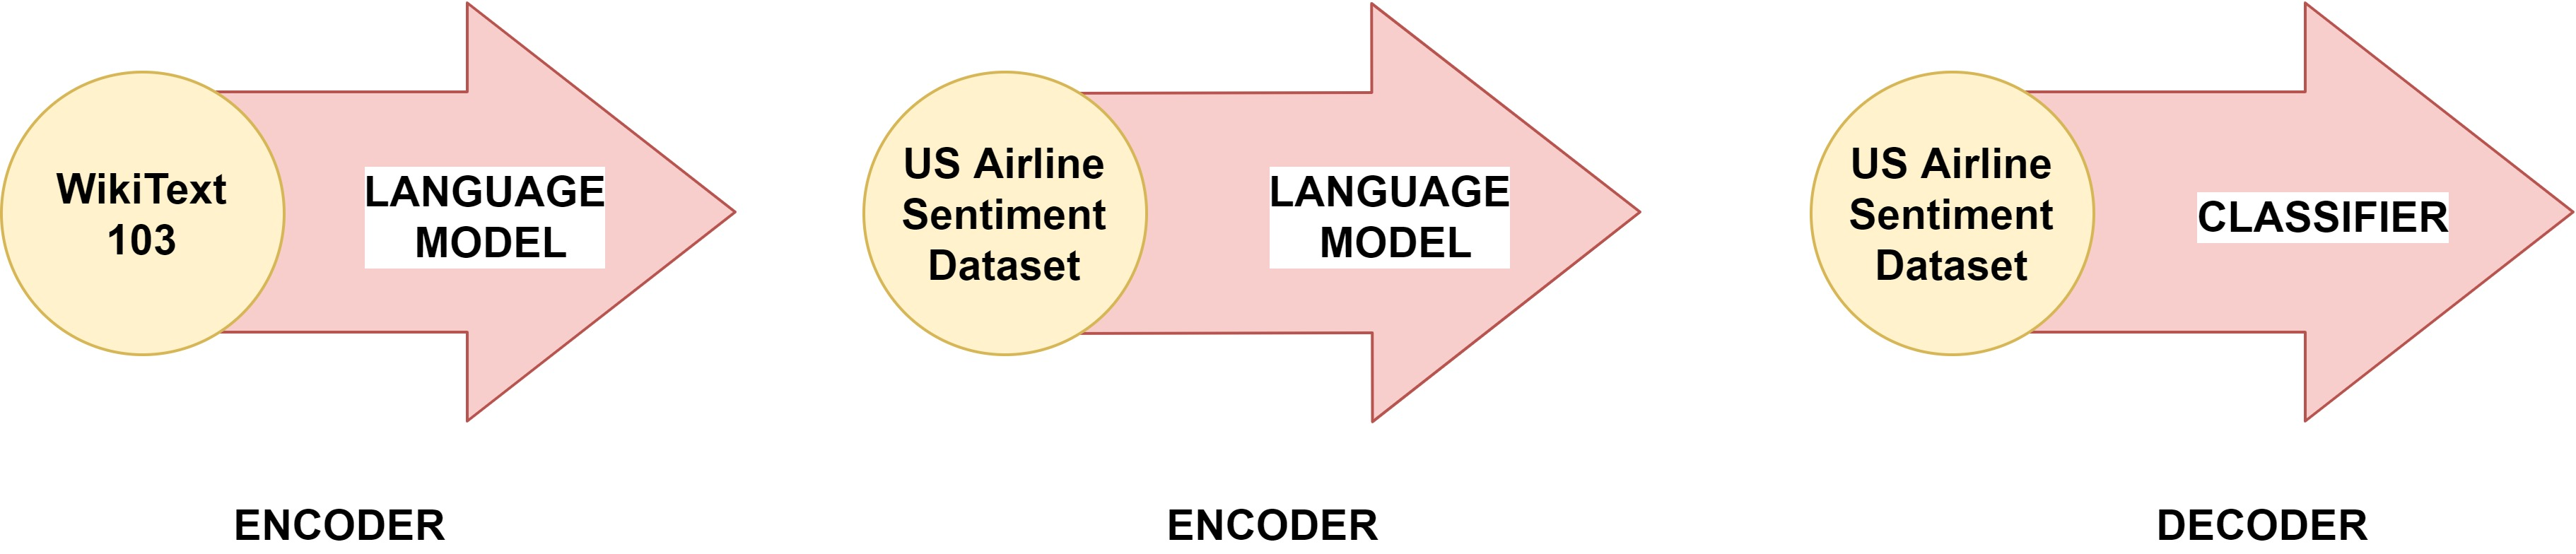

In [54]:
from IPython.display import Image
Image('/content/G-drive/My Drive/ULMFiT.jpg')

In [26]:
#Access to dataset from Google Drive
from google.colab import drive
drive.mount('/content/G-drive')

Drive already mounted at /content/G-drive; to attempt to forcibly remount, call drive.mount("/content/G-drive", force_remount=True).


In [27]:
#Importing Dependencies.


# For Data Manipulation
import pandas as pd
import numpy as np

# For text preprocessing
import nltk 
import string
import re
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')


# Fast.ai library for preprocessing and model
from fastai.text import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
df = pd.read_csv("/content/G-drive/My Drive/Fellowship/Tweets_main.csv")

In [29]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,latitude,longitude
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,35.888455,-119.273781
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,37.770971,-119.941025
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,35.684863,-119.709299
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,37.061159,-119.279135
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,36.790587,-120.867752


In [30]:
#Preparation of the data that is to fed into the network. 
# Removal of the following texts : 
# Punctuation
# Conversion to lower-Case
# URLs
# Usernames
# Hashtag

def preprocess_tweet(text):

    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # convert text to lower-case
    nopunc = nopunc.lower()
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', nopunc)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    #remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    regrex_pattern.sub(r'',nopunc)
   
    return nopunc

In [31]:
df['text'] = df['text'].apply(lambda x: preprocess_tweet(x))

In [32]:
df = df[['text','airline_sentiment']]

In [33]:
# Splitting of training and validation data. We have set our test size to 10% of the total dataset. 
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size=0.1,random_state=20)


In [34]:
df_train.to_csv('twitter_data_processed_train.csv')
df_test.to_csv('twitter_data_processed_test.csv')

In [35]:
# Using the Fast.ai API, we create a Language model for US Airline dataset. As we can see we are here buling the endcoder part, hence we dont focus 
# on the target, we are trying to learn and fine tune our model weight using th US dataset. hence just the text is being shown
# for our validation , we have selected 10% of the dataset. 

data_lm = TextLMDataBunch.from_csv(path='',csv_name='twitter_data_processed_train.csv',valid_pct=0.1)

data_lm.show_batch()

idx,text
0,to dallas to see my grand baby that i miss so much i feel like a piece of my heart is there xxbos americanair you should be contacting her for a refund dm me and i will provide phone number xxbos united ua has been rolling out improvements too we think hoping they ll catch up soon meantime ana is our preference xxbos jetblue what else could possibly take the
1,are being told to stay on the plane have nt pulled up to the gate amp have little to no information xxbos americanair dm sent answer me please xxbos southwestair i need to request a refund on my flight that was cancelled flightled this morning due to the weather xxbos southwestair incredible view i had a smooth flight both ways even tho there was turbulence your pilots rock xxbos “
2,flight xxbos usairways we ca nt help you we do nt put people up in hotels when you miss a flight its against policy xxbos southwestair appreciate the reply hopefully those lax agents get the memo cheers xxbos jetblue at what point do u cancelled flight flights to dca other airlines have already cancelled flightled xxbos usairways batting 1000 four flights in a month all four delayed xxbos americanair when
3,xxunk and unhelpful i also spoke xxbos jetblue seriously system down no it xxbos virginamerica you guys are perfect as always lt3 xxunk xxbos usairways thanks however i feel like the system has failed me what is the solution xxbos united assistance with what the attitude of your staff no matter which airport we are at xxbos united xxunk guys stop cancelled flightling flights from ewr to ric the weather
4,amp realize that transfers should be possible for tickets xxbos jetblue amazingly awesome customer service from your reservation agents tonight helping correct a mistake i so love this airline xxbos usairways xxunk be prepared for 3 hours hold times xxbos americanair come on i just want to go home i ca nt miss another day of work stuckinmemphis texasisclosed xxbos united bag was finally delivered and intact thanks for your


In [36]:
# We are passing our laguage model in the learner , data_lm 
# and the AWD_LSTM model. We set the drop_mult to 0.2.
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.2)

In [37]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(5872, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(5872, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=5872, bias=True)
    (output_dp): RNNDropout()
  )
)

In [38]:
# we call lr_find to determine the learning rate of our model 

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


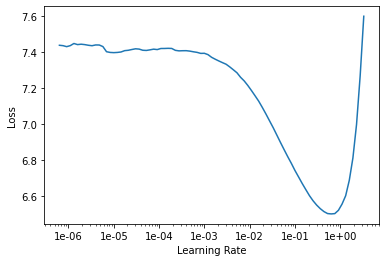

In [39]:
# Plotting the learning rate graph
learn.recorder.plot()

In [40]:
# we have taken our maximum LR as 1e-1, a little more than our minimum loss LR. 
# Then set the cycle_len to 1 to start with one epoch training
learn.fit_one_cycle(cyc_len=1,max_lr=1e-1,moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,5.261958,4.650843,0.192820,00:08


In [41]:
# unfreeze the LSTM layers of the model
learn.unfreeze()

# Train our encoder for 5 epochs.
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-1/(2.6**4),1e-1), moms=(0.85, 0.75))

epoch,train_loss,valid_loss,accuracy,time
0,4.429304,4.496502,0.201935,00:10
1,4.360145,4.449345,0.209970,00:10
2,4.039694,4.442480,0.218229,00:10
3,3.378982,4.698690,0.217448,00:10
4,2.450310,5.185833,0.211049,00:10


In [42]:
# save the encoder 
learn.save_encoder('Encoder')

In [43]:
# creating the TextClasDataBunch and pass our vocabulary
data_class = TextClasDataBunch.from_csv(path='',csv_name='twitter_data_processed_train.csv',
                              vocab=data_lm.train_ds.vocab,bs=32,text_cols='text',label_cols='airline_sentiment')

data_class.show_batch(5)

text,target
xxbos united i know i ’m sure you hear it all the time — do n’t like the new seats i ’m a small guy 5 ’ 6 ” and i feel the new planes are tight,negative
xxbos usairways if you get my bag from e gate to b gate at the charlotte airport before my 6 pm flight late flight cause of y all i ’ll ride us for life,negative
xxbos jetblue i ca nt do that flight i need a late flightr one i need you to change my flight you guys changed it and now i ca nt do that time,negative
xxbos southwestair i enjoyed a call from my good friend he s flight booking problems his flights elsewhere as i tweet one at a time i will tell as many as i can,neutral
xxbos usairways i get some bs from a guy at the door says door closes 10 minutes before it backs out yet i know for a fact it was 5 people short,negative


In [44]:
# we create a new learner object and set a little higher drop_mult
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.3)

# Loading our encoder
learn.load_encoder('Encoder')

# model architecture
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(5872, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(5872, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.12, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, e

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


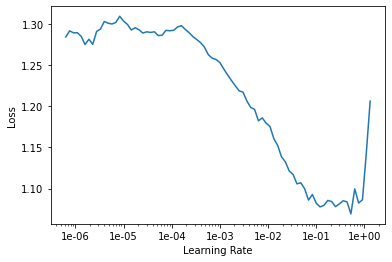

In [45]:
# Finding and plotting learning rate
learn.lr_find()

learn.recorder.plot()

In [46]:

learn.fit_one_cycle(5,3e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.707141,0.579750,0.760243,00:06
1,0.653533,0.596240,0.768209,00:06
2,0.668441,0.568950,0.775038,00:06
3,0.590145,0.538063,0.779970,00:06
4,0.594288,0.541717,0.780728,00:06


In [47]:
# unfreeze next layer
learn.freeze_to(-2)

# train with next layer unfrozen
learn.fit_one_cycle(3,slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.551415,0.521204,0.792109,00:07
1,0.528105,0.513068,0.799317,00:07
2,0.386848,0.522281,0.798179,00:07


In [48]:
# repeating the process
learn.freeze_to(-3)
learn.fit_one_cycle(3,slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.387565,0.552327,0.794765,00:12
1,0.308897,0.591835,0.795903,00:12
2,0.169105,0.604641,0.801593,00:11


In [49]:
# Unfreezing everything. 
learn.unfreeze()
learn.fit_one_cycle(3,slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.237201,0.658664,0.782625,00:15
1,0.200395,0.709587,0.799317,00:15
2,0.102405,0.737570,0.800076,00:15
